<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/ML_AI24_HT7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 7: Fraud Detection Competition**

Добро пожаловать на финальное домашнее задание курса! Домашнее задание направлено на систематизацию всех знаний, полученных в процессе учебы.

В нём Вы потренируетесь применять навыки построения пайплайнов машинного обучения, приобретенные в курсе от точки разведочного анализа данных до построения и валидации моделей машинного обучения.

## **Задача**
**Вы будете решать задачу определения фрода:**

https://www.kaggle.com/competitions/fraud-detection-24

**Вам нужно будет:**
- в jupyter notebook провести исследование данных;
- в нём же построить модели и оценить их качество;
- отправить посылку на Kaggle.

Более подробное описание шагов - в ноутбуке ниже.

## **Оценивание и баллы**
- В EDA и во всей работе будут оцениваться полнота и **выводы**;
- При обучении моделей старайтесь обоснованно подходить к их выбору, избегая простого перебора;

**Максимальный балл** - 10 (+ бонусы за Kaggle, см. ниже).


Мягкий дедлайн (окончание соревнования на Kaggle): **15 марта 23:59**


### **Примечания:**

**1. Оценка качества и Submission File**
- Ответом является число от 0 до 1, метрикой качества - AUC-ROC.
- Структура Submission File:
 - для каждого значения *TransactionID* в тестовых данных вы должны предсказать **вероятность** для столбца *isFraud*.
 - в файле у вас должно быть две колонки: `TransactionID` и`isFraud`  **для каждой транзакции в датасете**.

**2. Объем данных**

Поскольку набор данных объемный, могут быть проблемы с переполнением памяти в Collab. Для решения проблемы можете использовать функцию из [этого ноутбука](https://colab.research.google.com/drive/18u75eyFGEoyeWJ_MbsLkcPa6gv2tNI8G#scrollTo=V2L1Nl5CTMMl), разобравшись, что она делает с данными.

In [1]:
import os

import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import shutup
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from tqdm import tqdm
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import (
    cross_val_score,
    StratifiedKFold,
    train_test_split
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV, RFE
from sklearn.preprocessing import (
    OneHotEncoder,
    Normalizer,
    StandardScaler
)
from sklearn.metrics import (
    roc_auc_score,
    recall_score,
    precision_recall_curve,
    f1_score
)
from sklearn.utils import compute_class_weight
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.cluster import KMeans, DBSCAN

In [2]:
%matplotlib inline

INPUT_DIR = ''
RANDOM_STATE = 23

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
shutup.please()

In [3]:
def reduce_mem_usage(df):
    NAlist = [] # Keeps track of columns that have missing values filled in.
    for col in tqdm(df.columns):
        if df[col].dtype != object:  # Exclude strings

            # make variables for Int, max and min
            IsInt = False
            col_max_value = df[col].max()
            col_min_value = df[col].min()

            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all():
                NAlist.append(col)
                df[col].fillna(col_min_value - 1, inplace=True)

            # test if column can be converted to an integer
            col_as_int = df[col].fillna(0).astype(np.int64)
            diff = (df[col] - col_as_int)
            diff = diff.sum()
            if np.abs(diff) < 0.01:
                IsInt = True

            # Make Integer/unsigned Integer datatypes
            if pd.api.types.is_integer_dtype(df[col]):
                if col_min_value >= 0:
                    if col_max_value < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif col_max_value < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif col_max_value < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if col_min_value > np.iinfo(np.int8).min and col_max_value < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif col_min_value > np.iinfo(np.int16).min and col_max_value < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif col_min_value > np.iinfo(np.int32).min and col_max_value < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif col_min_value > np.iinfo(np.int64).min and col_max_value < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)

    return df, NAlist

In [4]:
train_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'data/train_transaction.csv'))
train_identity = pd.read_csv(os.path.join(INPUT_DIR, 'data/train_identity.csv'))
test_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'data/test_transaction.csv'))
test_identity = pd.read_csv(os.path.join(INPUT_DIR, 'data/test_identity.csv'))
sample_submission = pd.read_csv(os.path.join(INPUT_DIR, 'data/sample_submission.csv'))

df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')
del train_transaction, train_identity
df_train, df_train_NAlist = reduce_mem_usage(df_train)

df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')
del test_transaction, test_identity
df_test, df_test_NAlist = reduce_mem_usage(df_test)

df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)

100%|██████████| 433/433 [00:32<00:00, 13.26it/s] 


# **Задание 1 (2 балла)**

Проведите EDA (разведочный анализ данных):
* проанализируйте признаки, их особенности и связь с целевой переменной
* проанализируйте целевую переменную
* оцените степень попарной взаимосвязи признаков, а также связи признаков и целевой переменной
* по результатам исследований сделайте необходимую обработку данных (удаление дублей, работа с пропусками, с категориальными столбцами (если они есть), работа с аномалиями, другие преобразования признаков)

Важно, что EDA всегда сопровождается выводами - не забудьте об этом.

## Проанализируйте признаки, их особоенности и связь с целевой переменной

In [ ]:
df_train

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,68.500000,W,13926,99.0,150.0,discover,142.0,credit,315.0,87.0,19.0,-1.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,-1.0,13.0,-123.0,-1.0,-84.0,-1.0,-1.000000,-1.000000,13.0,13.0,-84.0,-1.0,-194.0,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,117.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,117.000000,0.000000,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-101.0,29.0,-13.0,-29.0,-73.0,-10

`Большое кол-во признаков, каждый проанализировать не получится. Соберём топы признаков по разным разрезам EDA.`

### Пропущенные значения

In [ ]:
df_nans = df_train\
    .isna()\
    .sum()\
    / df_train.shape[0]
df_nans = df_nans[df_nans >= 0.7]

df_nans.count()

18

In [ ]:
df_train[df_nans.index].describe()

,R_emaildomain,id_12,id_15,id_16,id_23,id_27,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,103820,110666,108273,99590,3954,3954,108273,108273,62096,107961,57819,62168,108273,108273,108273,108273,108124,91959
unique,60,2,3,2,3,2,2,2,71,110,183,4,2,2,2,2,2,1551
top,gmail.com,NotFound,Found,NotFound,IP_PROXY:TRANSPARENT,Found,Found,Found,Windows 10,chrome 63.0,1920x1080,match_status:2,T,F,T,T,desktop,Windows
freq,43010,96010,50788,50090,2635,3945,57753,56554,16078,21821,13466,46931,62152,102536,84398,57779,66324,36841


`Почти половина признаков имеют больше 70% пропущенных значений. Изучив признаки мы видим, что в них присутсвуют значения '0', которые указывают на то, что пропущенные значения это не значит, что прошло 0 дней для признаков, связанных с датой. Про id говорить не стоит. Предлагается удалить эти признаки.`

In [ ]:
df_train.drop(columns=df_nans.index, inplace=True)

### Признаки с низкой дисперсией

In [ ]:
df_low_corr = df_train\
    .nunique()\
    .sort_values(ascending=False)\
    / df_train.shape[0]

df_low_corr.head(10)

id_02             0.220833
V307              0.067191
V127              0.043771
V308              0.039745
TransactionAmt    0.038375
V310              0.036347
card1             0.029397
V306              0.027177
D8                0.026150
V317              0.025812
dtype: float64

In [ ]:
df_train['V307'].unique()

array([ 117.    ,    0.    , 1758.    , ..., 6329.85  ,  622.5678,
       2682.5   ], dtype=float32)

`Признаки имеют хорошую дисперсию, удалять ничего не буду.`

### Выбросы

In [5]:
object_cols = []
interval_cols = []

for idx, col in tqdm(enumerate(df_train.columns.drop('isFraud'))):
    if df_train[col].dtype == 'O':
        object_cols.append(col)

for idx, col in tqdm(enumerate(df_train.columns.drop('isFraud'))):
    if df_train[col].dtype != 'O':
        interval_cols.append(col)

431it [00:00, 46621.41it/s]
431it [00:00, 287217.19it/s]


In [ ]:
def count_outliers(series: pd.Series) -> int:
    """
    Подсчёт кол-ва выбросов в серии без пропущенных значений с помощью IQR.

    Parameters
    ----------
    series : pd.DataFrame
        Кадр данных.

    Returns
    -------
    outliers : int
        Кол-во выбросов в серии.
    """
    series.dropna(inplace=True)

    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)

    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = series[~((series >= lower_bound) & (series <= upper_bound))].shape[0]

    return outliers

In [ ]:
df_outliers_count = pd.DataFrame(
    data=df_train[interval_cols].apply(lambda column: count_outliers(series=column)),
    columns=['outliers']
).sort_values(by='outliers', ascending=False)
df_outliers_count = df_outliers_count[df_outliers_count['outliers'] > 0]
df_outliers_count = df_outliers_count / df_train.shape[0]

In [ ]:
df_outliers_count.head(20)

,outliers
V93,0.293247
V92,0.293235
V94,0.283787
V81,0.281754
V80,0.281654
V85,0.280952
V84,0.280758
V79,0.278581
V74,0.273928
V72,0.272019


In [ ]:
def keep_outliers(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns=object_cols)

    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_processed = df[((df < lower_bound) | (df > upper_bound)).any(axis=1)]

    return df_processed.index

In [ ]:
index = keep_outliers(df=df_train)
df_train[df_train.index.isin(index)].reset_index(drop=True)['isFraud'].value_counts()

0    359245
1     14721
Name: isFraud, dtype: int64

In [ ]:
df_train['isFraud'].value_counts()

0    402838
1     14721
Name: isFraud, dtype: int64

`Все положительные классы лежат в индексах, соответствующих выбросам. Выбросы не трогаю - всё таки задача типа анти-фрод.`

### Дубликаты

In [ ]:
df_train[df_train.duplicated()]

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
5847,0,663.710022,W,2884,490.0,150.0,visa,226.0,debit,264.0,87.0,-1.0,-1.0,yahoo.com,2.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-1.0,-1.0,-123.0,-1.0,-84.0,-1.0,-1.0,-1.0,0.0,-54.0,-84.0,-1.0,-194.0,-84.0,NaN,NaN,NaN,NaN,NaN,T,NaN,NaN,NaN,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-101.0,29.0,-13.0,-29.0,-73.0,-101.0,-47.0,-101.0,-37.0,-101.0,89.0,9.0,-661.0,99.0,9.0,99.0,99.0,99.0,9.0,10.0,99.0,99.0,-1.0
18691,0,117.000000,W,7664,490.0,150.0,visa,226.0,debit,264.0,87.0,-1.0,-1.0,yahoo.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0

`Есть небольшое кол-во дубликатов. Удалим их.`

In [ ]:
df_train.drop_duplicates(inplace=True)

## Однофакторный анализ

### Целевая переменная

In [ ]:
df_train['isFraud'].isna().any()

False

In [ ]:
df_train['isFraud'].value_counts(normalize=True)

0    0.964722
1    0.035278
Name: isFraud, dtype: float64

`Очень большой перекос в целевой переменной. Для оценки модели нужно использовать recall, pr-auc. Также на этапе моделирования необходимо рассчитать вес для каждого класса.`

## Двухфакторный анализ

In [ ]:
numeric_correlation = df_train.corr(method='pearson', numeric_only=True)
numeric_correlation = numeric_correlation[
    (numeric_correlation >= 0.5) |\
    (numeric_correlation <= -0.5)
]

<Axes: >

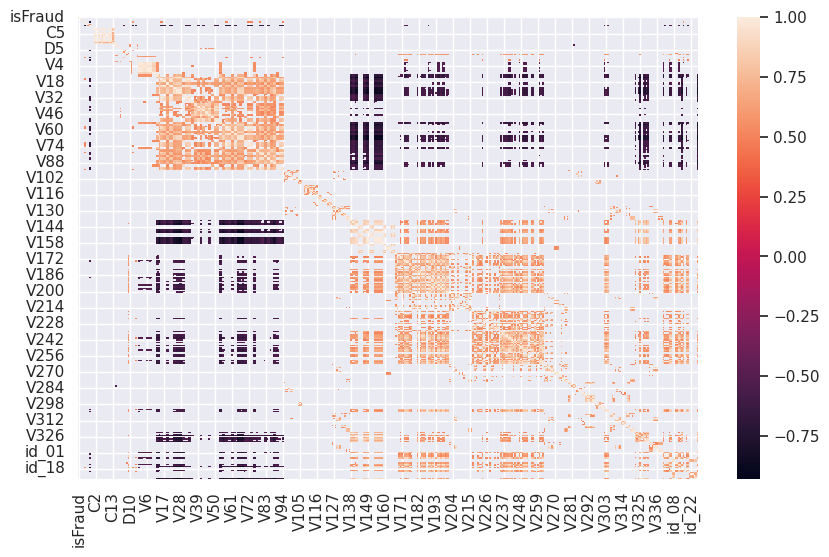

In [ ]:
sns.set_theme(rc={'figure.figsize': (10, 6)})
sns.heatmap(data=numeric_correlation)

`Видно, что с целевой переменной ни один из числовых признаков особо не коррелирует. Возможна нелинейная связь.`

In [ ]:
phik_overview = df_train[object_cols + ['isFraud']]\
    .phik_matrix(interval_cols=interval_cols, dropna=True)

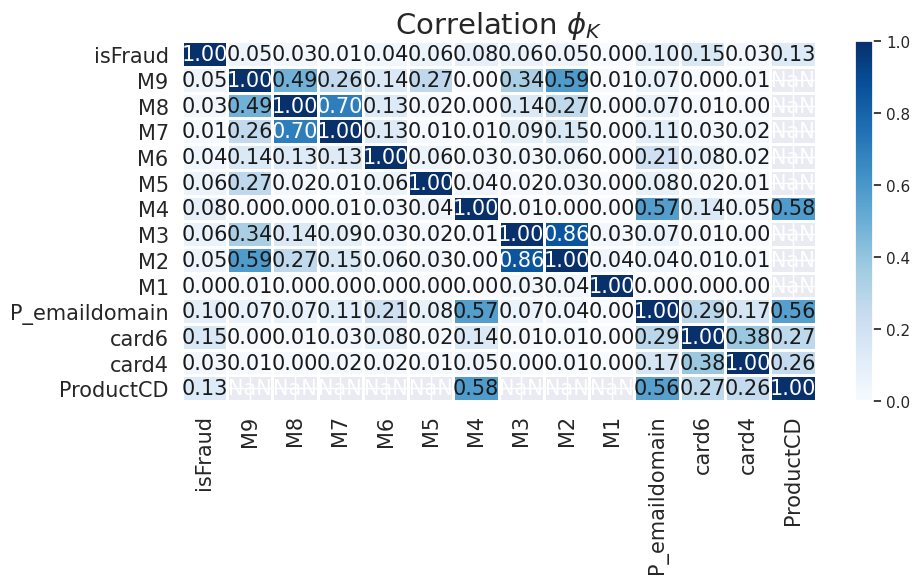

In [ ]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    color_map='Blues',
    title=r'Correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(10, 6)
)
plt.tight_layout()

`Также не наблюдается корреляции между категориальными признаками и целевой переменной.`

## Выводы по EDA
```
1. Общие сведения:
    - Большой объём данных, необходим отбор признаков или сокращение размерности;
    - Почти половина признаков имеет более 70% пропусков, признаки были удалены;
    - Признаки имеют хорошую дисперсию, удаления не требуется;
    - Все значения, содержающие выбросы, относятся к положительному классу, что не удивительно, так как задача типа анти-фрод;
    - Было удалено небольшое кол-во дубликатов.
2. Однофакторный анализ:
    - Очень большой перекос в целевой переменной. Для оценки модели нужно использовать recall, pr-auc. Также на этапе моделирования необходимо рассчитать вес для каждого класса.
3. Двухфакторный анализ:
    - Ни один из числовых или категориальных признаков не коррелирует с целевой переменной, но возможна нелинейная связь.
```

# **Задание 2 (3 балла)**

Обучите несколько ML-моделей для решения поставленной задачи.
Оцените их качество двумя способами:

1) на кросс-валидации

2) на лидерборде

Подберите число фолдов на кросс-валидации так, чтобы метрики, которые вы видите, были максимально близки на кросс-валидации и на лидерборде.

По результатам экспериментов постройте таблицу:
* в каждой строке таблицы - результаты одной модели
* по столбцам: качество на кросс-валидации, качество на лидерборде, модель с гиперпараметрами
Полученную таблицу вставьте картинкой прямо в ноутбук после ячеек с кодом. Сделайте текстовые выводы.

In [6]:
X = df_train.drop(columns=['isFraud'])
y = df_train['isFraud']

X_test = df_test

In [7]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weight_dict = dict(zip(np.unique(y), class_weights))

In [10]:
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_transformer', numeric_transformer, interval_cols),
        ('categorical_transformer', categorical_transformer, object_cols),
    ],
    n_jobs=-1
)
preprocessor = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('decomposition', PCA(n_components=90, random_state=RANDOM_STATE))
    ]
)

In [ ]:
X_preprocessed = preprocessor.fit_transform(X)
X_test_preprocessed = preprocessor.transform(X_test)

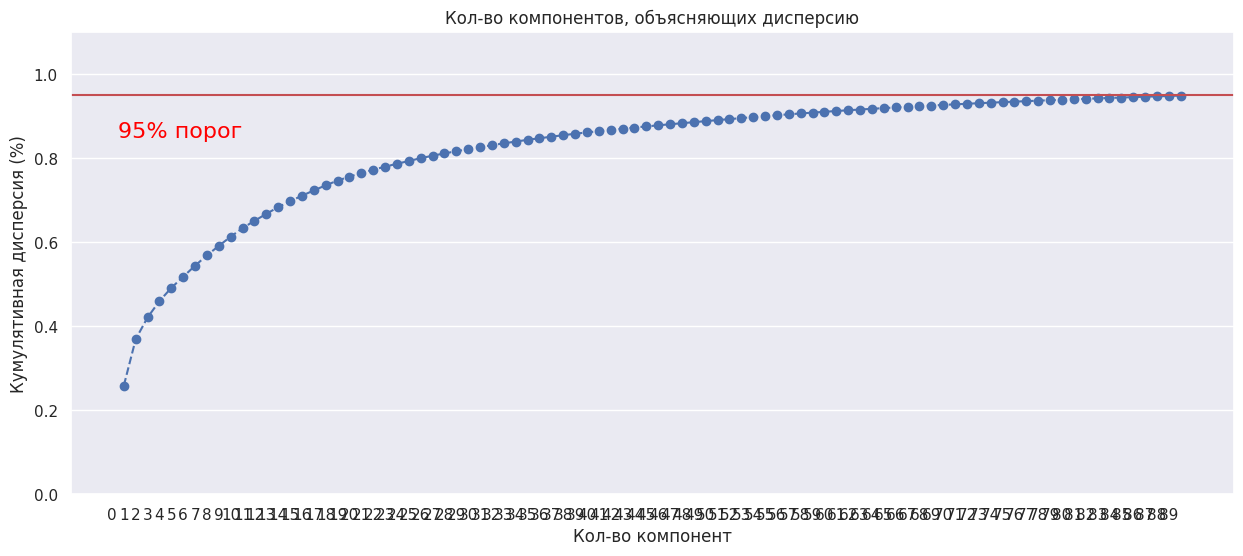

In [ ]:
plt.rcParams['figure.figsize'] = (15, 6)

fig, ax = plt.subplots()
xi = np.arange(1, 91, step=1)
yi = np.cumsum(preprocessor.steps[1][1].explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

plt.xlabel('Кол-во компонент')
plt.xticks(np.arange(0, 90, step=1))
plt.ylabel('Кумулятивная дисперсия (%)')
plt.title('Кол-во компонентов, объясняющих дисперсию')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% порог', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [ ]:
df_results = pd.DataFrame(
    data=None,
    columns=['model', 'cross_val_score', 'leaderboard_score', 'hyperparameters']
)

## Логистическая регрессия

In [ ]:
cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=RANDOM_STATE
)

estimator_lr = RFECV(
    estimator=LogisticRegression(
        class_weight=class_weight_dict,
        random_state=RANDOM_STATE
    ),
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

estimator_lr.fit(X=X_preprocessed, y=y)
y_pred = estimator_lr.predict_proba(X=X_test_preprocessed)

In [ ]:
sub = pd.DataFrame(
    data={
        'TransactionID': sample_submission['TransactionID'],
        'isFraud': y_pred[:, 1]
    }
)
sub.to_csv(INPUT_DIR + 'submissions/submission_lr.csv', index=False)

In [ ]:
df_results.loc[0] = [
    'logistic_regression',
    estimator_lr.cv_results_['mean_test_score'].max(),
    0.82131,
    None
]

## DecisionTreeClassifier

In [ ]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    estimator = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight=class_weight_dict,
        random_state=RANDOM_STATE
    )

    scores = cross_val_score(
        estimator=estimator,
        X=X_preprocessed,
        y=y,
        scoring='roc_auc',
        cv=cv,
        n_jobs=-1
    )

    return np.mean(scores)

In [ ]:
study_dtc = optuna.create_study(direction='maximize')
study_dtc.optimize(objective, n_trials=25, n_jobs=-1, show_progress_bar=True)

[I 2025-03-11 12:53:45,369] A new study created in memory with name: no-name-10cb9efb-bc76-45dd-8748-b9f67c5a1df5
Best trial: 2. Best value: 0.748591:   4%|▍         | 1/25 [01:07<27:05, 67.74s/it]

[I 2025-03-11 12:54:53,108] Trial 2 finished with value: 0.7485910256115808 and parameters: {'max_depth': 13, 'min_samples_split': 17, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.7485910256115808.


Best trial: 2. Best value: 0.748591:   8%|▊         | 2/25 [02:19<26:50, 70.00s/it]

[I 2025-03-11 12:56:04,690] Trial 6 finished with value: 0.7233531387721781 and parameters: {'max_depth': 15, 'min_samples_split': 12, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.7485910256115808.


Best trial: 2. Best value: 0.748591:  12%|█▏        | 3/25 [02:25<15:00, 40.91s/it]

[I 2025-03-11 12:56:10,982] Trial 0 finished with value: 0.7473037646503725 and parameters: {'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.7485910256115808.


Best trial: 5. Best value: 0.803679:  16%|█▌        | 4/25 [02:55<12:47, 36.54s/it]

[I 2025-03-11 12:56:40,808] Trial 5 finished with value: 0.8036792133376253 and parameters: {'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 5 with value: 0.8036792133376253.


Best trial: 7. Best value: 0.818439:  20%|██        | 5/25 [02:59<08:17, 24.87s/it]

[I 2025-03-11 12:56:44,992] Trial 7 finished with value: 0.8184389779770308 and parameters: {'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.8184389779770308.


Best trial: 7. Best value: 0.818439:  24%|██▍       | 6/25 [03:08<06:09, 19.42s/it]

[I 2025-03-11 12:56:53,845] Trial 1 finished with value: 0.6853775666415416 and parameters: {'max_depth': 19, 'min_samples_split': 12, 'min_samples_leaf': 1}. Best is trial 7 with value: 0.8184389779770308.


Best trial: 7. Best value: 0.818439:  28%|██▊       | 7/25 [03:28<05:52, 19.59s/it]

[I 2025-03-11 12:57:13,788] Trial 3 finished with value: 0.7494167257637966 and parameters: {'max_depth': 13, 'min_samples_split': 12, 'min_samples_leaf': 5}. Best is trial 7 with value: 0.8184389779770308.
[I 2025-03-11 12:57:13,818] Trial 4 finished with value: 0.7380263969709867 and parameters: {'max_depth': 14, 'min_samples_split': 16, 'min_samples_leaf': 10}. Best is trial 7 with value: 0.8184389779770308.


Best trial: 7. Best value: 0.818439:  36%|███▌      | 9/25 [04:08<05:17, 19.85s/it]

[I 2025-03-11 12:57:54,045] Trial 9 finished with value: 0.8100366734569345 and parameters: {'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 4}. Best is trial 7 with value: 0.8184389779770308.


Best trial: 7. Best value: 0.818439:  40%|████      | 10/25 [04:13<04:00, 16.06s/it]

[I 2025-03-11 12:57:59,118] Trial 8 finished with value: 0.6973214456344609 and parameters: {'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 7 with value: 0.8184389779770308.


Best trial: 7. Best value: 0.818439:  44%|████▍     | 11/25 [04:33<03:57, 16.98s/it]

[I 2025-03-11 12:58:18,614] Trial 11 finished with value: 0.7913359387842399 and parameters: {'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 3}. Best is trial 7 with value: 0.8184389779770308.


Best trial: 7. Best value: 0.818439:  48%|████▊     | 12/25 [04:56<04:02, 18.66s/it]

[I 2025-03-11 12:58:41,669] Trial 10 finished with value: 0.7208307010829937 and parameters: {'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 7 with value: 0.8184389779770308.


Best trial: 7. Best value: 0.818439:  52%|█████▏    | 13/25 [05:22<04:10, 20.84s/it]

[I 2025-03-11 12:59:07,996] Trial 12 finished with value: 0.7353506224527551 and parameters: {'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.8184389779770308.


Best trial: 7. Best value: 0.818439:  56%|█████▌    | 14/25 [05:45<03:54, 21.34s/it]

[I 2025-03-11 12:59:30,595] Trial 13 finished with value: 0.7472906844899989 and parameters: {'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 7 with value: 0.8184389779770308.


Best trial: 7. Best value: 0.818439:  60%|██████    | 15/25 [06:18<04:08, 24.87s/it]

[I 2025-03-11 13:00:03,995] Trial 14 finished with value: 0.7820616393499931 and parameters: {'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 2}. Best is trial 7 with value: 0.8184389779770308.


Best trial: 7. Best value: 0.818439:  64%|██████▍   | 16/25 [06:27<03:02, 20.23s/it]

[I 2025-03-11 13:00:13,128] Trial 15 finished with value: 0.7816016202569834 and parameters: {'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 7 with value: 0.8184389779770308.


Best trial: 7. Best value: 0.818439:  68%|██████▊   | 17/25 [06:37<02:17, 17.17s/it]

[I 2025-03-11 13:00:23,017] Trial 17 finished with value: 0.7701809421105067 and parameters: {'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 7}. Best is trial 7 with value: 0.8184389779770308.


Best trial: 7. Best value: 0.818439:  72%|███████▏  | 18/25 [06:54<01:58, 16.96s/it]

[I 2025-03-11 13:00:39,479] Trial 16 finished with value: 0.7358814313929435 and parameters: {'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 7 with value: 0.8184389779770308.


Best trial: 7. Best value: 0.818439:  76%|███████▌  | 19/25 [07:13<01:46, 17.67s/it]

[I 2025-03-11 13:00:58,823] Trial 18 finished with value: 0.8168609262468945 and parameters: {'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 7}. Best is trial 7 with value: 0.8184389779770308.


Best trial: 7. Best value: 0.818439:  80%|████████  | 20/25 [07:34<01:33, 18.69s/it]

[I 2025-03-11 13:01:19,909] Trial 19 finished with value: 0.8170068936684824 and parameters: {'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.8184389779770308.


Best trial: 7. Best value: 0.818439:  84%|████████▍ | 21/25 [07:52<01:13, 18.37s/it]

[I 2025-03-11 13:01:37,541] Trial 20 finished with value: 0.8170068936684824 and parameters: {'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.8184389779770308.


Best trial: 7. Best value: 0.818439:  88%|████████▊ | 22/25 [08:03<00:48, 16.32s/it]

[I 2025-03-11 13:01:49,046] Trial 21 finished with value: 0.8170068936684824 and parameters: {'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.8184389779770308.


Best trial: 7. Best value: 0.818439:  92%|█████████▏| 23/25 [08:15<00:29, 14.89s/it]

[I 2025-03-11 13:02:00,582] Trial 22 finished with value: 0.8184389779770308 and parameters: {'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.8184389779770308.


Best trial: 7. Best value: 0.818439:  96%|█████████▌| 24/25 [08:28<00:14, 14.29s/it]

[I 2025-03-11 13:02:13,467] Trial 23 finished with value: 0.8184389779770308 and parameters: {'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.8184389779770308.


Best trial: 7. Best value: 0.818439: 100%|██████████| 25/25 [08:38<00:00, 20.72s/it]

[I 2025-03-11 13:02:23,439] Trial 24 finished with value: 0.8183803694832229 and parameters: {'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 5}. Best is trial 7 with value: 0.8184389779770308.


In [ ]:
estimator_dtc = DecisionTreeClassifier(
    **study_dtc.best_params,
    class_weight=class_weight_dict,
    random_state=RANDOM_STATE
)
calibrated_estimator_dtc = CalibratedClassifierCV(
    estimator=estimator_dtc,
    method='sigmoid',
    cv=cv,
    n_jobs=-1
)

calibrated_estimator_dtc.fit(X=X_preprocessed, y=y)
y_pred = calibrated_estimator_dtc.predict_proba(X=X_test_preprocessed)

In [ ]:
sub = pd.DataFrame(
    data={
        'TransactionID': sample_submission['TransactionID'],
        'isFraud': y_pred[:, 1]
    }
)
sub.to_csv(INPUT_DIR + 'submissions/submission_dtc.csv', index=False)

In [ ]:
df_results.loc[1] = ['decision_tree_classifier', study_dtc.best_value, 0.81601, study_dtc.best_params]

## LGBMClassifier

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 4, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)

    estimator = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        class_weight=class_weight_dict,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    scores = cross_val_score(
        estimator=estimator,
        X=X_preprocessed,
        y=y,
        scoring='roc_auc',
        cv=cv,
        n_jobs=-1
    )

    return np.mean(scores)

In [ ]:
study_lgbmc = optuna.create_study(direction='maximize')
study_lgbmc.optimize(objective, n_trials=25, n_jobs=-1, show_progress_bar=True)

[I 2025-03-11 13:02:52,147] A new study created in memory with name: no-name-2befdae1-8ad9-456d-991c-50e1f5f1cf62
Best trial: 0. Best value: 0.874149:   4%|▍         | 1/25 [00:28<11:28, 28.67s/it]

[I 2025-03-11 13:03:20,813] Trial 0 finished with value: 0.8741487647813311 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.08102879393367951}. Best is trial 0 with value: 0.8741487647813311.


Best trial: 5. Best value: 0.880539:   8%|▊         | 2/25 [00:45<08:24, 21.92s/it]

[I 2025-03-11 13:03:38,001] Trial 5 finished with value: 0.8805389854160953 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.09582217178504467}. Best is trial 5 with value: 0.8805389854160953.


Best trial: 4. Best value: 0.889325:  12%|█▏        | 3/25 [01:24<10:50, 29.59s/it]

[I 2025-03-11 13:04:16,720] Trial 4 finished with value: 0.8893250779952749 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.10397126756628117}. Best is trial 4 with value: 0.8893250779952749.


Best trial: 4. Best value: 0.889325:  16%|█▌        | 4/25 [02:17<13:32, 38.69s/it]

[I 2025-03-11 13:05:09,365] Trial 2 finished with value: 0.8872642259202322 and parameters: {'n_estimators': 600, 'max_depth': 10, 'learning_rate': 0.1678684987500009}. Best is trial 4 with value: 0.8893250779952749.


Best trial: 4. Best value: 0.889325:  20%|██        | 5/25 [02:41<11:12, 33.65s/it]

[I 2025-03-11 13:05:34,051] Trial 3 finished with value: 0.8641859500748099 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.09714415412489637}. Best is trial 4 with value: 0.8893250779952749.


Best trial: 7. Best value: 0.892928:  24%|██▍       | 6/25 [02:51<08:02, 25.40s/it]

[I 2025-03-11 13:05:43,461] Trial 7 finished with value: 0.8929281839197399 and parameters: {'n_estimators': 700, 'max_depth': 8, 'learning_rate': 0.07848017666151623}. Best is trial 7 with value: 0.8929281839197399.


Best trial: 7. Best value: 0.892928:  28%|██▊       | 7/25 [03:57<11:36, 38.68s/it]

[I 2025-03-11 13:06:49,483] Trial 1 finished with value: 0.8878231818711612 and parameters: {'n_estimators': 800, 'max_depth': 9, 'learning_rate': 0.15098575056209299}. Best is trial 7 with value: 0.8929281839197399.


Best trial: 7. Best value: 0.892928:  32%|███▏      | 8/25 [04:33<10:41, 37.75s/it]

[I 2025-03-11 13:07:25,245] Trial 8 finished with value: 0.8885151129137826 and parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.04324806530907393}. Best is trial 7 with value: 0.8929281839197399.


Best trial: 7. Best value: 0.892928:  36%|███▌      | 9/25 [04:57<08:56, 33.54s/it]

[I 2025-03-11 13:07:49,535] Trial 10 finished with value: 0.8272505904991156 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.010791500851087118}. Best is trial 7 with value: 0.8929281839197399.


Best trial: 6. Best value: 0.89374:  40%|████      | 10/25 [05:25<07:59, 31.96s/it]

[I 2025-03-11 13:08:17,953] Trial 6 finished with value: 0.8937398486602083 and parameters: {'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.03961305784611602}. Best is trial 6 with value: 0.8937398486602083.


Best trial: 6. Best value: 0.89374:  44%|████▍     | 11/25 [05:43<06:28, 27.72s/it]

[I 2025-03-11 13:08:36,056] Trial 9 finished with value: 0.8793458989771942 and parameters: {'n_estimators': 600, 'max_depth': 6, 'learning_rate': 0.2613385730251212}. Best is trial 6 with value: 0.8937398486602083.


Best trial: 6. Best value: 0.89374:  48%|████▊     | 12/25 [05:49<04:34, 21.10s/it]

[I 2025-03-11 13:08:42,033] Trial 12 finished with value: 0.8754043637408531 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.08288418498930078}. Best is trial 6 with value: 0.8937398486602083.


Best trial: 6. Best value: 0.89374:  52%|█████▏    | 13/25 [07:15<08:07, 40.63s/it]

[I 2025-03-11 13:10:07,576] Trial 11 finished with value: 0.884562538626522 and parameters: {'n_estimators': 900, 'max_depth': 8, 'learning_rate': 0.1741829037472915}. Best is trial 6 with value: 0.8937398486602083.


Best trial: 6. Best value: 0.89374:  56%|█████▌    | 14/25 [08:21<08:51, 48.35s/it]

[I 2025-03-11 13:11:13,781] Trial 13 finished with value: 0.875768609138747 and parameters: {'n_estimators': 700, 'max_depth': 10, 'learning_rate': 0.010836125072767945}. Best is trial 6 with value: 0.8937398486602083.


Best trial: 6. Best value: 0.89374:  60%|██████    | 15/25 [09:54<10:17, 61.77s/it]

[I 2025-03-11 13:12:46,651] Trial 14 finished with value: 0.8787360542493765 and parameters: {'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.011755313614653446}. Best is trial 6 with value: 0.8937398486602083.


Best trial: 6. Best value: 0.89374:  64%|██████▍   | 16/25 [10:02<06:49, 45.52s/it]

[I 2025-03-11 13:12:54,439] Trial 15 finished with value: 0.8934505345570237 and parameters: {'n_estimators': 700, 'max_depth': 9, 'learning_rate': 0.06925373053527718}. Best is trial 6 with value: 0.8937398486602083.


Best trial: 6. Best value: 0.89374:  68%|██████▊   | 17/25 [10:40<05:46, 43.27s/it]

[I 2025-03-11 13:13:32,460] Trial 16 finished with value: 0.8830465433059902 and parameters: {'n_estimators': 800, 'max_depth': 6, 'learning_rate': 0.1801872803446175}. Best is trial 6 with value: 0.8937398486602083.


Best trial: 6. Best value: 0.89374:  72%|███████▏  | 18/25 [12:05<06:31, 55.91s/it]

[I 2025-03-11 13:14:57,811] Trial 17 finished with value: 0.8914328150935674 and parameters: {'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.02980782471163067}. Best is trial 6 with value: 0.8937398486602083.


Best trial: 6. Best value: 0.89374:  76%|███████▌  | 19/25 [13:12<05:54, 59.10s/it]

[I 2025-03-11 13:16:04,342] Trial 18 finished with value: 0.8913436676638778 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.027399988745342725}. Best is trial 6 with value: 0.8937398486602083.


Best trial: 6. Best value: 0.89374:  80%|████████  | 20/25 [14:17<05:04, 60.91s/it]

[I 2025-03-11 13:17:09,470] Trial 19 finished with value: 0.8930087912907768 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.0354915320041273}. Best is trial 6 with value: 0.8937398486602083.


Best trial: 6. Best value: 0.89374:  84%|████████▍ | 21/25 [15:37<04:26, 66.59s/it]

[I 2025-03-11 13:18:29,316] Trial 20 finished with value: 0.8924808612666263 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.032053218383934615}. Best is trial 6 with value: 0.8937398486602083.


Best trial: 6. Best value: 0.89374:  88%|████████▊ | 22/25 [16:05<02:45, 55.19s/it]

[I 2025-03-11 13:18:57,919] Trial 21 finished with value: 0.8927617722457084 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.034691038572137275}. Best is trial 6 with value: 0.8937398486602083.


Best trial: 6. Best value: 0.89374:  92%|█████████▏| 23/25 [17:41<02:14, 67.31s/it]

[I 2025-03-11 13:20:33,498] Trial 22 finished with value: 0.8927363269713658 and parameters: {'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.03401282714431227}. Best is trial 6 with value: 0.8937398486602083.


Best trial: 6. Best value: 0.89374:  96%|█████████▌| 24/25 [18:22<00:59, 59.33s/it]

[I 2025-03-11 13:21:14,199] Trial 23 finished with value: 0.8935065671119782 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.03626358822552463}. Best is trial 6 with value: 0.8937398486602083.


Best trial: 6. Best value: 0.89374: 100%|██████████| 25/25 [18:45<00:00, 45.01s/it]

[I 2025-03-11 13:21:37,336] Trial 24 finished with value: 0.8918099055091412 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.029402079462297778}. Best is trial 6 with value: 0.8937398486602083.


In [ ]:
estimator_lgbmc = LGBMClassifier(
    **study_lgbmc.best_params,
    class_weight=class_weight_dict,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
calibrated_estimator_lgbmc = CalibratedClassifierCV(
    estimator=estimator_lgbmc,
    method='isotonic',
    cv=cv,
    n_jobs=-1
)

calibrated_estimator_lgbmc.fit(X=X_preprocessed, y=y)
y_pred = calibrated_estimator_lgbmc.predict_proba(X=X_test_preprocessed)

In [ ]:
sub = pd.DataFrame(
    data={
        'TransactionID': sample_submission['TransactionID'],
        'isFraud': y_pred[:, 1]
    }
)
sub.to_csv(INPUT_DIR + 'submissions/submission_lgbmc.csv', index=False)

In [ ]:
df_results.loc[2] = ['lightgbm_classifier', study_lgbmc.best_value, 0.83423, study_lgbmc.best_params]

## StackingClassifier

In [ ]:
estimator_sc = StackingClassifier(
    estimators=[
        ('dtc', calibrated_estimator_dtc),
        ('lgbmc', calibrated_estimator_lgbmc)
    ],
    final_estimator=estimator_lr,
    n_jobs=-1
)

estimator_sc.fit(X=X_preprocessed, y=y)
y_pred = estimator_sc.predict_proba(X=X_test_preprocessed)

In [ ]:
sub = pd.DataFrame(
    data={
        'TransactionID': sample_submission['TransactionID'],
        'isFraud': y_pred[:, 1]
    }
)
sub.to_csv(INPUT_DIR + 'submissions/submission_sc.csv', index=False)

In [ ]:
df_results.loc[3] = [
    'stacking_classifier',
    0.86532535255,
    0.84025,
    estimator_sc.get_params()
]

## VotingClassifier

In [ ]:
estimator_vc = VotingClassifier(
    estimators=[
        ('dtc', calibrated_estimator_dtc),
        ('lgbmc', calibrated_estimator_lgbmc),
        ('lr', estimator_lr)
    ],
    voting='soft',
    n_jobs=-1
)

estimator_vc.fit(X=X_preprocessed, y=y)
y_pred = estimator_vc.predict_proba(X=X_test_preprocessed)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
sub = pd.DataFrame(
    data={
        'TransactionID': sample_submission['TransactionID'],
        'isFraud': y_pred[:, 1]
    }
)
sub.to_csv(INPUT_DIR + 'submissions/submission_vc.csv', index=False)

In [ ]:
df_results.loc[4] = [
    'voting_classifier',
    0.85235905325,
    0.83511,
    estimator_vc.get_params()
]

In [ ]:
df_results.iloc[1]['hyperparameters'],\
df_results.iloc[2]['hyperparameters']

({'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 6},
 {'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.03961305784611602})

In [ ]:
df_results

,model,cross_val_score,leaderboard_score,hyperparameters
0,logistic_regression,0.835234,0.82131,None
1,decision_tree_classifier,0.818439,0.81601,"{'max_depth': 7, 'min_samples_split': 18, 'min..."
2,lightgbm_classifier,0.893740,0.83423,"{'n_estimators': 1000, 'max_depth': 7, 'learni..."
3,stacking_classifier,0.865325,0.84025,"{'cv': None, 'estimators': [('dtc', Calibrated..."
4,voting_classifier,0.852359,0.83511,"{'estimators': [('dtc', CalibratedClassifierCV..."


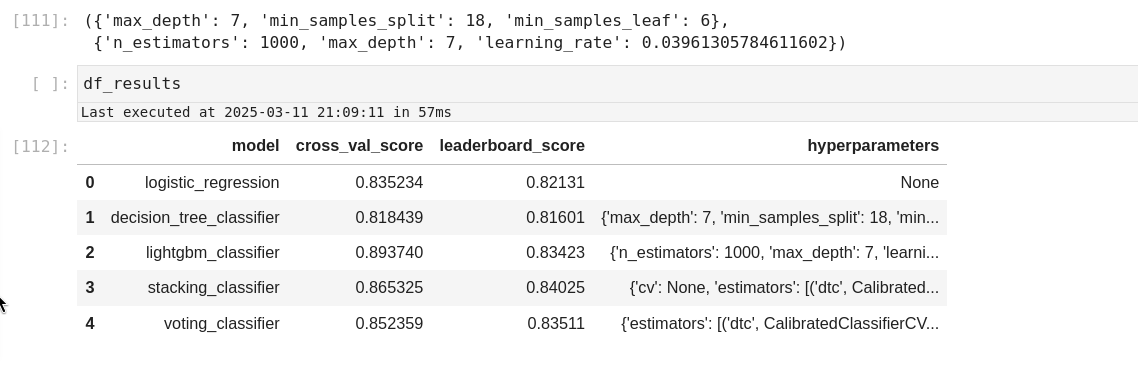
`
Я постарался применить максимум полученных знаний в рамках курса. Пусть мои пайплайны выглядят неоптимизированно, а подбор гиперпараметров поверхностный, но я просто получил удовольствие от того, что завернул свои модели в больших ML-монстров и оставил обучаться. Лучший балл набрала модель.
`

# **Задание 3 (2 балла)**

Попробуйте подойти к задаче как к поиску аномалий.

1) Поищите аномалии (фрод) различными рассмотренными в курсе методами и сделайте прогноз на тестовых данных.

Результатом также будет таблица:
* по строкам - методы поиска аномалий
* по столбцам - качество вашего решения на leaderboard

2) Попробуйте встроить поиск аномалий и их удаление в ML-пайплайн: найдите аномалии и что-нибудь с ними сделайте до обучения моделей (можно удалить их, а можно использовать в качестве дополнительных признаков - попробуйте разные стратегии). Результат проверьте на кросс-валидации и на лидерборде, сделайте выводы.

In [10]:
df_results_anomaly = pd.DataFrame(
    data=None,
    columns=['model', 'cross_val_score', 'leaderboard_score']
)

`Я хочу использовать свой прошлый пайплайн для обработки данных как основу, но использую TruncatedSVD вместо PCA в этот раз, чтобы просто разнообразить свой код, мы же учимся и изучаем разные подходы. Удаление выбросов я не буду рассматривать, так как все записи, являющиеся выбросами, являются положительным классом, это было показано на этапе EDA.`

In [8]:
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_transformer', numeric_transformer, interval_cols),
        ('categorical_transformer', categorical_transformer, object_cols),
    ],
    n_jobs=-1
)
preprocessor = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('decomposition', TruncatedSVD(n_components=90, random_state=RANDOM_STATE))
    ]
)

In [12]:
X_anomaly = preprocessor.fit_transform(X=X)
X_test_anomaly = preprocessor.transform(X=X_test)

## IsolationForest

In [13]:
isolation_forest = IsolationForest(n_jobs=-1, random_state=RANDOM_STATE)

if_train = isolation_forest.fit_predict(X=X_anomaly)
if_test = isolation_forest.predict(X=X_test_anomaly)

In [14]:
X_anomaly_if = np.hstack((X_anomaly, if_train.reshape(-1, 1)))
X_test_anomaly_if = np.hstack((X_test_anomaly, if_test.reshape(-1, 1)))

In [15]:
cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=RANDOM_STATE
)

estimator_lr = RFECV(
    estimator=LogisticRegression(
        max_iter=200,
        class_weight=class_weight_dict,
        random_state=RANDOM_STATE
    ),
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

estimator_lr.fit(X=X_anomaly_if, y=y)
y_pred = estimator_lr.predict_proba(X=X_test_anomaly_if)

In [16]:
sub = pd.DataFrame(
    data={
        'TransactionID': sample_submission['TransactionID'],
        'isFraud': y_pred[:, 1]
    }
)
sub.to_csv(INPUT_DIR + 'submissions/submission_if.csv', index=False)

In [17]:
df_results_anomaly.loc[0] = [
    'isolation_forest',
    estimator_lr.cv_results_['mean_test_score'].max(),
    0.82165
]

## LocalOutlierFactor

In [18]:
lof_not_novelty = LocalOutlierFactor(n_jobs=-1, novelty=False)

lof_train = lof_not_novelty.fit_predict(X=X_anomaly)

In [19]:
lof_novelty = LocalOutlierFactor(n_jobs=-1, novelty=True)

lof_novelty.fit(X=X_anomaly)
lof_test = lof_novelty.predict(X=X_test_anomaly)

In [20]:
X_anomaly_lof = np.hstack((X_anomaly, lof_train.reshape(-1, 1)))
X_test_anomaly_lof = np.hstack((X_test_anomaly, lof_test.reshape(-1, 1)))

In [21]:
cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=RANDOM_STATE
)

estimator_lr = RFECV(
    estimator=LogisticRegression(
        max_iter=200,
        class_weight=class_weight_dict,
        random_state=RANDOM_STATE
    ),
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

estimator_lr.fit(X=X_anomaly_lof, y=y)
y_pred = estimator_lr.predict_proba(X=X_test_anomaly_lof)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [22]:
sub = pd.DataFrame(
    data={
        'TransactionID': sample_submission['TransactionID'],
        'isFraud': y_pred[:, 1]
    }
)
sub.to_csv(INPUT_DIR + 'submissions/submission_lof.csv', index=False)

In [23]:
df_results_anomaly.loc[1] = [
    'local_outlier_factor',
    estimator_lr.cv_results_['mean_test_score'].max(),
    0.81855
]

## OneClassSVM

In [ ]:
ocsvm = OneClassSVM(kernel='linear')

ocsvm_train = ocsvm.fit_predict(X=X_anomaly)
ocsvm_test = ocsvm.predict(X=X_test_anomaly)

In [ ]:
X_anomaly_ocsvm = np.hstack((X_anomaly, ocsvm_train.reshape(-1, 1)))
X_test_anomaly_ocsvm = np.hstack((X_test_anomaly, ocsvm_test.reshape(-1, 1)))

In [ ]:
cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=RANDOM_STATE
)

estimator_lr = RFECV(
    estimator=LogisticRegression(
        max_iter=200,
        class_weight=class_weight_dict,
        random_state=RANDOM_STATE
    ),
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

estimator_lr.fit(X=X_anomaly_ocsvm, y=y)
y_pred = estimator_lr.predict_proba(X=X_test_anomaly_ocsvm)

In [ ]:
sub = pd.DataFrame(
    data={
        'TransactionID': sample_submission['TransactionID'],
        'isFraud': y_pred[:, 1]
    }
)
sub.to_csv(INPUT_DIR + 'submissions/submission_ocsvm.csv', index=False)

In [25]:
df_results_anomaly.loc[2] = [
    'one_class_svm',
    estimator_lr.cv_results_['mean_test_score'].max(),
    0.81752
]

In [26]:
df_results_anomaly

,model,cross_val_score,leaderboard_score
0,isolation_forest,0.835756,0.82165
1,local_outlier_factor,0.837833,0.81855
2,one_class_svm,0.837701,0.81752


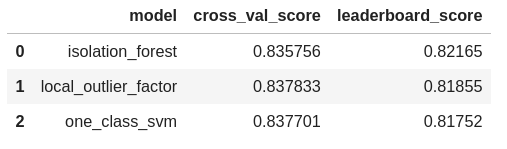

`
Мне понравилось изучать различные техники по поиску аномалий, за ними стоят интересные идеи. К сожалению, хорошего результата по лидерборду мне не удалось достичь, эти подходы незначительно повлияли на мой скор.
`

# **Задание 4 (1 балл)**

Сделайте кластеризацию различными способами. Результаты кластеризации используйте для улучшения ML-решений:

1) Номера кластеров закодируйте (OHE или target-encoding) и добавьте как новые признаки

2) При использовании DBSCAN / HDBSCAN предсказанный шум можно трактовать как найденную аномалию и также добавить ее как новый признак

Проведите различные эксперименты. Проверьте как эти подходы влияют на качество прогнозов по кросс-валидации и на лидерборде, сделайте выводы.

In [9]:
df_results_cluster = pd.DataFrame(
    data=None,
    columns=['model', 'cross_val_score', 'leaderboard_score']
)

In [10]:
X_cluster = preprocessor.fit_transform(X=X)
X_test_cluster = preprocessor.transform(X=X_test)

## KMeans

In [11]:
kmeans = KMeans(random_state=RANDOM_STATE)

kmeans_train = kmeans.fit_predict(X=X_cluster)
kmeans_test = kmeans.predict(X=X_test_cluster)

In [38]:
kmeans_encoder = OneHotEncoder(handle_unknown='ignore')

kmeans_train_encoded = kmeans_encoder.fit_transform(kmeans_train.reshape(-1, 1)).toarray()
kmeans_test_encoded = kmeans_encoder.transform(kmeans_test.reshape(-1, 1)).toarray()

In [40]:
X_cluster_kmeans = np.hstack((X_cluster, kmeans_train_encoded))
X_test_cluster_kmeans = np.hstack((X_test_cluster, kmeans_test_encoded))

In [42]:
cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=RANDOM_STATE
)

estimator_lr = RFECV(
    estimator=LogisticRegression(
        class_weight=class_weight_dict,
        random_state=RANDOM_STATE
    ),
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

estimator_lr.fit(X=X_cluster_kmeans, y=y)
y_pred = estimator_lr.predict_proba(X=X_test_cluster_kmeans)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [43]:
sub = pd.DataFrame(
    data={
        'TransactionID': sample_submission['TransactionID'],
        'isFraud': y_pred[:, 1]
    }
)
sub.to_csv(INPUT_DIR + 'submissions/submission_kmeans.csv', index=False)

In [44]:
df_results_cluster.loc[0] = [
    'kmeans',
    estimator_lr.cv_results_['mean_test_score'].max(),
    0.82220
]

## DBSCAN

In [46]:
dbscan = DBSCAN(n_jobs=-1)

dbscan_train = dbscan.fit_predict(X=X_cluster)
dbscan_test = dbscan.fit_predict(X=X_test_cluster)

In [47]:
dbscan_encoder = OneHotEncoder(handle_unknown='ignore')

dbscan_train_encoded = dbscan_encoder.fit_transform(dbscan_train.reshape(-1, 1)).toarray()
dbscan_test_encoded = dbscan_encoder.transform(dbscan_test.reshape(-1, 1)).toarray()

In [48]:
X_cluster_dbscan = np.hstack((X_cluster, dbscan_train.reshape(-1, 1)))
X_test_cluster_dbscan = np.hstack((X_test_cluster, dbscan_test.reshape(-1, 1)))

In [49]:
cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=RANDOM_STATE
)

estimator_lr = RFECV(
    estimator=LogisticRegression(
        class_weight=class_weight_dict,
        random_state=RANDOM_STATE
    ),
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

estimator_lr.fit(X=X_cluster_dbscan, y=y)
y_pred = estimator_lr.predict_proba(X=X_test_cluster_dbscan)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [50]:
sub = pd.DataFrame(
    data={
        'TransactionID': sample_submission['TransactionID'],
        'isFraud': y_pred[:, 1]
    }
)
sub.to_csv(INPUT_DIR + 'submissions/submission_dbscan.csv', index=False)

In [51]:
df_results_cluster.loc[1] = [
    'dbscan',
    estimator_lr.cv_results_['mean_test_score'].max(),
    0.82194
]

In [52]:
df_results_cluster

,model,cross_val_score,leaderboard_score
0,kmeans,0.835867,0.82220
1,dbscan,0.835486,0.82194


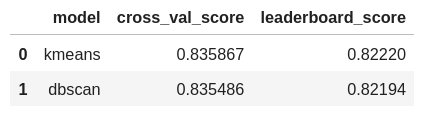

`
При работе с таким набором данных, было интересно научиться работать с разреженными матрицами, кодировать их, обучаться на них. В общем, кластеризация, также как и поиск аномалий, помогла немного улучшить метрики, но улучшила их сильнее, чем поиск аномалий.
`

# **Задание 5 (1 балл)**

Примените какой-нибудь (один любой) AutoML фреймворк для решения поставленной задачи.

Отправьте AutoML-прогноз на kaggle и посмотрите на качество модели. Сделайте текстовые выводы.

In [7]:
train_data = TabularDataset(data=df_train)
test_data = TabularDataset(data=df_test)
label = 'isFraud'

In [8]:
predictor = TabularPredictor(
    label=label,
    problem_type='binary',
    eval_metric='roc_auc'
)

predictor.fit(
    train_data=train_data,
    presets='high_quality'
)
y_pred = predictor.predict_proba(data=test_data, as_pandas=False)

No path specified. Models will be saved in: "AutogluonModels/ag-20250314_192610"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       8.74 GB / 12.67 GB (69.0%)
Disk Space Avail:   66.97 GB / 107.72 GB (62.2%)
Presets specified: ['high_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enable

In [10]:
sub = pd.DataFrame(
    data={
        'TransactionID': sample_submission['TransactionID'],
        'isFraud': y_pred[:, 1]
    }
)
sub.to_csv(INPUT_DIR + '/submissions/submission_automl.csv', index=False)

`
За полтора часа я обучил на Google Colab AutoGluon на шаблоне high_quality и получил 0.89691 балла на лидерборде, что является довольно неплохим результатом. Мне понравилась идея AutoML, можно строить несколько пайплайнов, брать лучший из них и изучать, почему он стал лучшим. Брать идеи из него.
`

# **Задание 6 (1 балл)**

Весь курс мы работали в Google Colab. Но всегда должны быть запасные варианты, где Вы будете обучать модели.

Среди вариантов есть:
* ваша локальная машина
* kaggle notebooks
* yandex cloud
и другие.

Кроме привычного Google Colab выберите из списка выше один любой альтернативный вариант и проведите эксперимент:

* Прогоните ваш лучший по качеству по результатам заданий 2-4 ML-пайплайн заново в Google Colab и с помощью библиотек (например, при помощи библиотеки time) замерьте время обучения и отдельно время инференса на тестовых данных

* Прогоните этот пайплайн на выбранном альтернативном сервисе/локальной машине и также замерьте время обучения и инференса.

Текстом напишите выводы: опишите, какое альтернативное место для обучения моделей Вы использовали? Прикрепите прямо в ноутбук скриншот с экраном кода в альтернативном сервисе/на локальной машине. Также в виде таблицы приведите сравнение времени обучения и инференса в колабе и в альтернативном месте. Сделайте выводы.

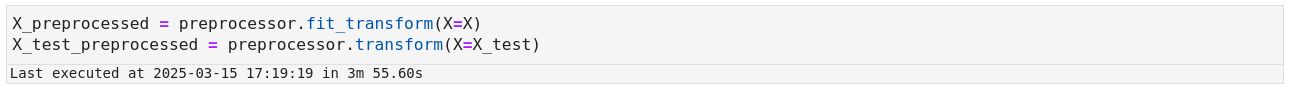
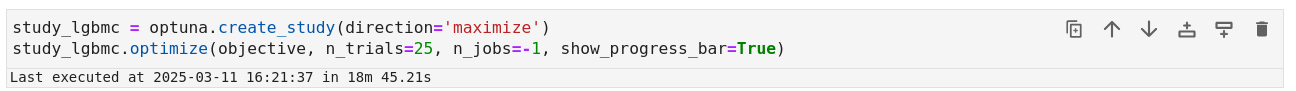
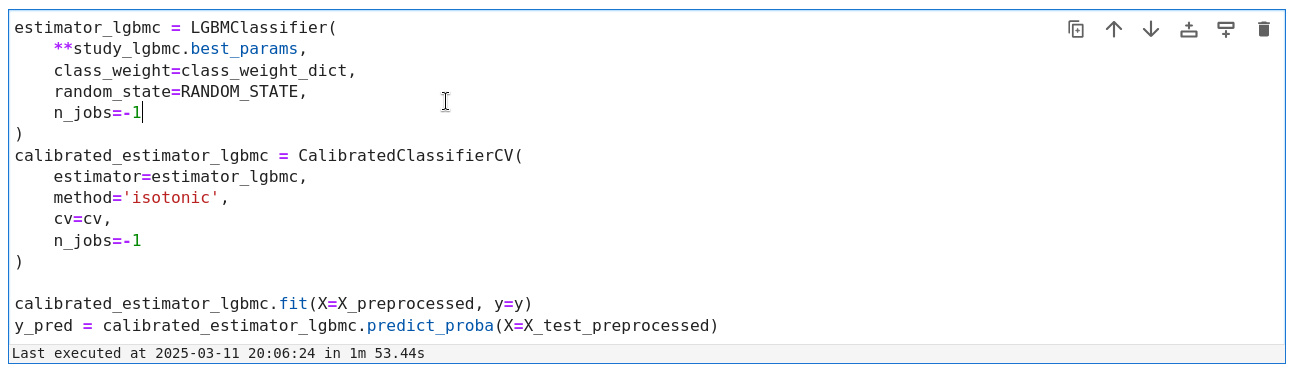
`
На скриншотах выше представлено время, за которое мой лучший пайплайн был реализован в Яндекс Дата Сфере, на самой мощной ВМ без GPU. Я изначально работал на локальной машине, но у неё не хватило мощности чтобы запустить любой из пайплайнов - не хватало памяти. Потом переместился в Google Colab, где мой пайплайн преобразовавал данные около десяти минут, оптимизировал параметры полтора часа, обучал и калибровал классификатор около 15 минут. Поэтому продолжил я работать за счёт гранта в Яндекс Дата Сфере.
`
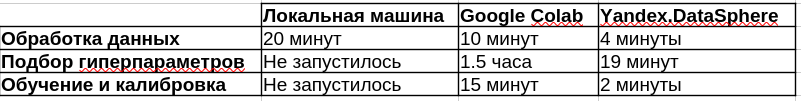

# **Бонус: за Kaggle и стремление к хорошим скорам (2 балла)**

В этом домашнем задании Ваша цель - не просто выполнить шаги выше, но и построить максимально хорошую по качеству модель.

**К 10 вы можете получить до двух дополнительных баллов:**

* За попадание в топ-20% на private leaderboard — +1 дополнительный балл к оценке
* За попадание в топ-5 мест на private leaderboard — + еще один дополнительный балл к оценке (то есть суммарно 2 дополнительных балла)

**ВАЖНО!!!**

Эти баллы ставятся до мягкого дедлайна по соревнованию. После мягкого дедлайна лидерборд не обновляется, и дополнительные баллы не ставятся.

Успехов!

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X.fillna(value=-1),
    y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y
)

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000, step=50),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'verbose': 1,
    }

    model = CatBoostClassifier(
        **params,
        cat_features=object_cols,
        class_weights=class_weight_dict,
        random_state=RANDOM_STATE,
        task_type='GPU'
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    score = roc_auc_score(y_val, y_pred)

    return score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

In [ ]:
estimator = CatBoostClassifier(
    **study.best_params,
    cat_features=object_cols,
    class_weights=class_weight_dict,
    random_state=RANDOM_STATE,
    task_type='GPU'
)

estimator.fit(X.fillna(-1), y)
y_pred = estimator.predict_proba(X_test.fillna(-1))

In [ ]:
sub = pd.DataFrame(
    data={
        'TransactionID': sample_submission['TransactionID'],
        'isFraud': y_pred[:, 1]
    }
)
sub.to_csv(INPUT_DIR + 'submissions/submission_optimized.csv', index=False)

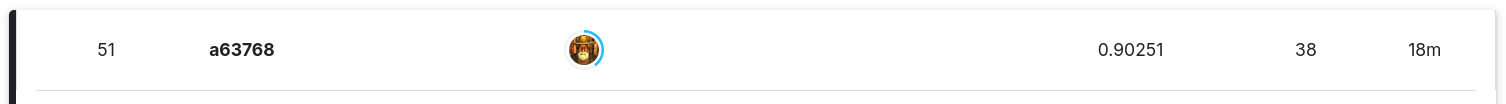
`
В рамках эксперимента попробовал обучить CatBoostClassifier на GPU и получил свой лучший результат, чем доволен!
`